# Homework with an asterisk

Try to improve the quality of the feedback classification model, which we analyzed at the webinar.

0. Disassemble the code from practice.

1. Look at the implementation of [LSTM in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html ). Play around with the num_layers, hidden_size and embedding_dim parameters: try increasing all 3 parameters at the same time and check how changing them will affect training.

2. When working with neural networks, you can often encounter retraining - the model "remembers" the training dataset, but does not teach general patterns. Read about the methods of combating retraining: [DropOut](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html ), [regularization of weights (weight decay)](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9 ), [Early Stopping](https://en.wikipedia.org/wiki/Early_stopping ), [Gradient clipping](https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch ). Apply any 2 methods, see how the learning process changes.

3. If the above methods do not help you improve the quality of predictions, try filtering the data. For example, we can submit only frequently occurring words to the input of the model and ignore those that are rarely found in the dataset.

For example, change the line

```
corpus_ = sorted(corpus,key=corpus.get,reverse=True)
```

on

```
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
```
to submit to the input of the model only the top 1000 frequently occurring words.

# Classification of movie reviews using LSTM

1. To begin work, the texts need to be tokenized - split into words and assign an id to each word
2. Then each word (token) must be passed to the embedding layer to get a compact vector
3. Embedding and transmitting to the input to the recurrent network (LSTM)
4. After processing the last word of the review, we make a prediction.

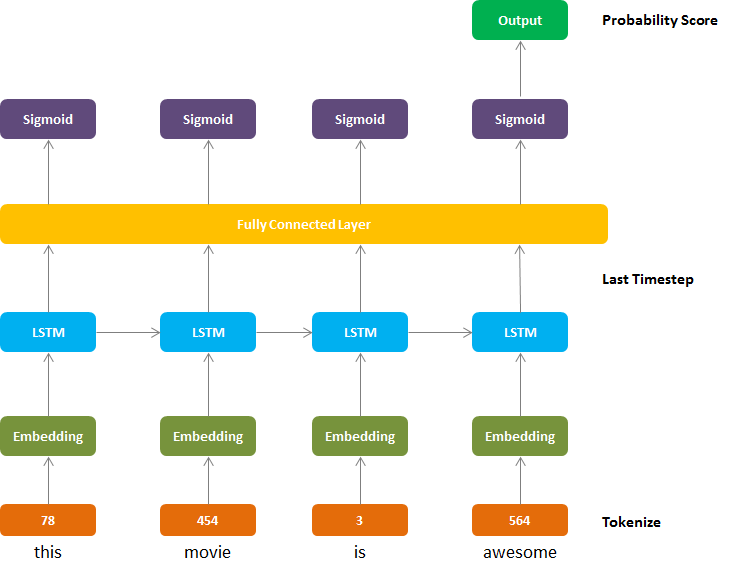

# Preparing the data

In [1]:
import numpy as np
from string import punctuation
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm

import random
random.seed(33)
torch.manual_seed(0)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Reading data from files
with open('drive/MyDrive/reviews.txt', 'r') as f:
    reviews = f.read()
with open('drive/MyDrive/labels.txt', 'r') as f:
    labels = f.read()

In [4]:
# Let's print the first 100 characters from the file with reviews and 9 characters from the file with labels
print(reviews[:100])
print(labels[:9])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life
positive



In [5]:
def preprocess(text):
    """"
   Function to split solid text into separate reviews, remove punctuation
and highlight all words
    """
    text = "".join([s for s in text if s not in punctuation]) # removing punctuation
    all_reviews = text.split("\n") # we divide the text into revues
    text = " ".join(all_reviews)
    all_words = text.split() # getting an array of words

    return all_reviews, all_words


all_reviews, all_words = preprocess(reviews)
print('Total number of reviews: ', len(all_reviews))

Total number of reviews:  25001


In [6]:
print('First two review: ', all_reviews[:2])
print('First five words: ', all_words[:5])

First two review:  ['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned in

In [7]:
corpus = Counter(all_words)
# Let's sort the words by occurrence
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
print('The most frequent words: ', corpus_[:10])
# we encode each word - assign it an ordinal number
vocab_to_int = {w:i+1 for i,w in enumerate(corpus_)}
print('Unique words: ', len(vocab_to_int))

# We encode all the reviews: a sequence of words --> a sequence of numbers
encoded_reviews = []
for sent in all_reviews:
  encoded_reviews.append([vocab_to_int[word] for word in sent.lower().split()
                                  if word in vocab_to_int.keys()])
print('Example of encoded review: ', encoded_reviews[0])

The most frequent words:  ['the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i']
Unique words:  1000
Example of encoded review:  [308, 6, 3, 207, 8, 32, 1, 171, 57, 15, 49, 81, 44, 382, 110, 140, 15, 60, 154, 9, 1, 475, 71, 5, 260, 12, 308, 13, 6, 74, 5, 613, 73, 6, 1, 5, 1, 36, 51, 66, 204, 145, 67, 1, 4, 1, 221, 883, 31, 71, 4, 1, 10, 686, 2, 67, 54, 10, 216, 1, 383, 9, 62, 3, 783, 5, 180, 1, 382, 10, 32, 308, 3, 349, 341, 10, 143, 127, 5, 30, 4, 129, 5, 308, 10, 528, 12, 109, 4, 60, 543, 102, 12, 308, 6, 227, 48, 3, 12, 8, 215, 23]


In [8]:
all_labels = labels.split("\n")
encoded_labels = [1 if label == "positive" else 0 for label in all_labels]

print('Number of reviews and number of labels: ', len(all_reviews), len(all_labels))

Number of reviews and number of labels:  25001 25001


In [9]:
encoded_labels = np.array( [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx]) > 0] )
encoded_reviews = [review for review in encoded_reviews if len(review) > 0]

print(len(encoded_labels), len(encoded_reviews))

25000 25000


Let's pack all sequences so that they have the same length seq_len and can be organized into tensors by butches

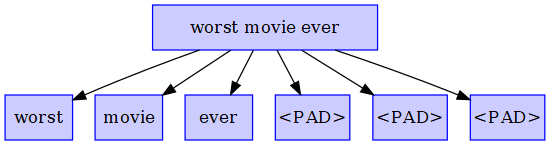

In [10]:
def pad_text(encoded_reviews, seq_length):
    reviews = []
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)

    return np.array(reviews)


padded_reviews = pad_text(encoded_reviews, seq_length = 200)

In [11]:
# dataset = TensorDataset(torch.from_numpy(padded_reviews), torch.from_numpy(encoded_labels))

train_set = TensorDataset(torch.from_numpy(padded_reviews[:20000]), torch.from_numpy(encoded_labels[:20000]))
val_set = TensorDataset(torch.from_numpy(padded_reviews[20000:]), torch.from_numpy(encoded_labels[20000:]))

In [12]:
batch_size = 128

# train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-5000, 5000])
print('The size of the training and validation dataset: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

The size of the training and validation dataset:  20000 5000


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Setting the model

In [14]:
class SentimentRNN(nn.Module):
    """
    Let's build a model for classifying texts
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        """
        Initialize the model by designating layers and hyperparameters
        """
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = num_layers, dropout=0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x, h):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, h)
        # print(lstm_out.shape)
        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # fully-connected layer
        out = self.fc(lstm_out)
        # sigmoid function
        out = self.sig(out)
        # return last sigmoid output
        return out

In [15]:
vocab_size = len(vocab_to_int)+1
embedding_dim = 100
hidden_dim = 256
num_layers = 2
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
model.to(device)

optimizer = torch.optim.Adam(params = model.parameters(), weight_decay=1e-5) # optimization algorithm
lr = 0.001 # learning rate

# Train

In [16]:
class ValueMeter(object):
  """
  Auxiliary class to track loss and metric
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Auxiliary function
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

In [17]:
def accuracy(outputs, labels):
    preds = torch.round(outputs.squeeze())
    # print(preds, labels)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
def trainval(model, loaders, optimizer, epochs=5):
  """
  model: model which we are going to train
  loaders: dictionary with dataloaders for training and validation
  optimizer: optimazer
  epochs: number of training epoch (how many times the model will running through the dataset)
  """
  loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
  accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

  loss_track = {'training': [], 'validation': []}
  accuracy_track = {'training': [], 'validation': []}

  for epoch in range(epochs): # iteration om epochs
      for mode in ['training', 'validation']: # training - validation
          # calculating the gradient only on training:
          with torch.set_grad_enabled(mode == 'training'):
              # depending on the phase, we switch the model to the desired mode:
              model.train() if mode == 'training' else model.eval()
              for texts, labels in tqdm(loaders[mode]):
                  texts = texts.to(device) # sending tensor to CPU/GPU
                  labels = labels.to(device)
                  bs = labels.shape[0]  # batch size (different for the last batch in loader)

                  zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
                  h = tuple([zero_init, zero_init]) # setting the initial hidden state of the model

                  preds = model(texts, h) # forward pass - we running the tensor with text through the model
                  loss = nn.BCELoss()(preds.squeeze(), labels.float())
                  loss_meter[mode].add(loss.item(), bs)

                  # if we are in the learning phase
                  if mode == 'training':
                      optimizer.zero_grad() # zero last gradient
                      loss.backward() # doing backward pass (calculating the gradient)
                      optimizer.step() # update weights

                  acc = accuracy(preds, labels) # calculating metrics
                  # storing loss and accuracy for butch
                  accuracy_meter[mode].add(acc, bs)

          # at the end of the phase, we output the values of loss and accuracy
          log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

          # we save the results for all epochs
          loss_track[mode].append(loss_meter[mode].value())
          accuracy_track[mode].append(accuracy_meter[mode].value())
  return loss_track, accuracy_track

In [19]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=30)

100%|██████████| 157/157 [00:10<00:00, 15.44it/s]


[training] Epoch: 0.00. Loss: 0.66. Accuracy: 60.97% 


100%|██████████| 40/40 [00:01<00:00, 39.33it/s]


[validation] Epoch: 0.00. Loss: 0.70. Accuracy: 50.00% 


100%|██████████| 157/157 [00:09<00:00, 15.79it/s]


[training] Epoch: 1.00. Loss: 0.68. Accuracy: 55.75% 


100%|██████████| 40/40 [00:01<00:00, 33.59it/s]


[validation] Epoch: 1.00. Loss: 0.70. Accuracy: 50.80% 


100%|██████████| 157/157 [00:10<00:00, 15.42it/s]


[training] Epoch: 2.00. Loss: 0.68. Accuracy: 54.68% 


100%|██████████| 40/40 [00:01<00:00, 35.09it/s]


[validation] Epoch: 2.00. Loss: 0.69. Accuracy: 50.98% 


100%|██████████| 157/157 [00:10<00:00, 15.40it/s]


[training] Epoch: 3.00. Loss: 0.68. Accuracy: 56.33% 


100%|██████████| 40/40 [00:00<00:00, 40.58it/s]


[validation] Epoch: 3.00. Loss: 0.67. Accuracy: 55.73% 


100%|██████████| 157/157 [00:09<00:00, 15.78it/s]


[training] Epoch: 4.00. Loss: 0.66. Accuracy: 59.10% 


100%|██████████| 40/40 [00:00<00:00, 40.37it/s]


[validation] Epoch: 4.00. Loss: 0.64. Accuracy: 59.70% 


100%|██████████| 157/157 [00:09<00:00, 15.98it/s]


[training] Epoch: 5.00. Loss: 0.62. Accuracy: 62.48% 


100%|██████████| 40/40 [00:00<00:00, 41.92it/s]


[validation] Epoch: 5.00. Loss: 0.60. Accuracy: 63.23% 


100%|██████████| 157/157 [00:10<00:00, 15.37it/s]


[training] Epoch: 6.00. Loss: 0.59. Accuracy: 65.41% 


100%|██████████| 40/40 [00:01<00:00, 38.38it/s]


[validation] Epoch: 6.00. Loss: 0.57. Accuracy: 66.07% 


100%|██████████| 157/157 [00:09<00:00, 16.16it/s]


[training] Epoch: 7.00. Loss: 0.56. Accuracy: 67.86% 


100%|██████████| 40/40 [00:01<00:00, 34.36it/s]


[validation] Epoch: 7.00. Loss: 0.54. Accuracy: 68.33% 


100%|██████████| 157/157 [00:09<00:00, 16.05it/s]


[training] Epoch: 8.00. Loss: 0.53. Accuracy: 69.87% 


100%|██████████| 40/40 [00:00<00:00, 41.32it/s]


[validation] Epoch: 8.00. Loss: 0.52. Accuracy: 70.12% 


100%|██████████| 157/157 [00:09<00:00, 15.79it/s]


[training] Epoch: 9.00. Loss: 0.51. Accuracy: 71.58% 


100%|██████████| 40/40 [00:00<00:00, 40.81it/s]


[validation] Epoch: 9.00. Loss: 0.51. Accuracy: 71.48% 


100%|██████████| 157/157 [00:09<00:00, 15.74it/s]


[training] Epoch: 10.00. Loss: 0.49. Accuracy: 73.05% 


100%|██████████| 40/40 [00:00<00:00, 40.98it/s]


[validation] Epoch: 10.00. Loss: 0.49. Accuracy: 72.64% 


100%|██████████| 157/157 [00:09<00:00, 15.76it/s]


[training] Epoch: 11.00. Loss: 0.47. Accuracy: 74.32% 


100%|██████████| 40/40 [00:01<00:00, 38.33it/s]


[validation] Epoch: 11.00. Loss: 0.48. Accuracy: 73.66% 


100%|██████████| 157/157 [00:09<00:00, 15.91it/s]


[training] Epoch: 12.00. Loss: 0.46. Accuracy: 75.47% 


100%|██████████| 40/40 [00:01<00:00, 33.88it/s]


[validation] Epoch: 12.00. Loss: 0.47. Accuracy: 74.49% 


100%|██████████| 157/157 [00:09<00:00, 15.84it/s]


[training] Epoch: 13.00. Loss: 0.44. Accuracy: 76.51% 


100%|██████████| 40/40 [00:00<00:00, 40.48it/s]


[validation] Epoch: 13.00. Loss: 0.46. Accuracy: 75.24% 


100%|██████████| 157/157 [00:09<00:00, 15.87it/s]


[training] Epoch: 14.00. Loss: 0.43. Accuracy: 77.48% 


100%|██████████| 40/40 [00:00<00:00, 40.90it/s]


[validation] Epoch: 14.00. Loss: 0.45. Accuracy: 75.86% 


100%|██████████| 157/157 [00:09<00:00, 15.95it/s]


[training] Epoch: 15.00. Loss: 0.41. Accuracy: 78.38% 


100%|██████████| 40/40 [00:00<00:00, 40.66it/s]


[validation] Epoch: 15.00. Loss: 0.45. Accuracy: 76.43% 


100%|██████████| 157/157 [00:09<00:00, 15.87it/s]


[training] Epoch: 16.00. Loss: 0.40. Accuracy: 79.25% 


100%|██████████| 40/40 [00:00<00:00, 40.42it/s]


[validation] Epoch: 16.00. Loss: 0.45. Accuracy: 76.94% 


100%|██████████| 157/157 [00:09<00:00, 16.14it/s]


[training] Epoch: 17.00. Loss: 0.39. Accuracy: 80.09% 


100%|██████████| 40/40 [00:01<00:00, 33.99it/s]


[validation] Epoch: 17.00. Loss: 0.44. Accuracy: 77.35% 


100%|██████████| 157/157 [00:09<00:00, 15.78it/s]


[training] Epoch: 18.00. Loss: 0.37. Accuracy: 80.91% 


100%|██████████| 40/40 [00:00<00:00, 41.03it/s]


[validation] Epoch: 18.00. Loss: 0.45. Accuracy: 77.72% 


100%|██████████| 157/157 [00:09<00:00, 15.94it/s]


[training] Epoch: 19.00. Loss: 0.36. Accuracy: 81.67% 


100%|██████████| 40/40 [00:00<00:00, 40.74it/s]


[validation] Epoch: 19.00. Loss: 0.45. Accuracy: 78.04% 


100%|██████████| 157/157 [00:09<00:00, 15.91it/s]


[training] Epoch: 20.00. Loss: 0.35. Accuracy: 82.39% 


100%|██████████| 40/40 [00:00<00:00, 40.43it/s]


[validation] Epoch: 20.00. Loss: 0.45. Accuracy: 78.32% 


100%|██████████| 157/157 [00:09<00:00, 15.80it/s]


[training] Epoch: 21.00. Loss: 0.34. Accuracy: 83.07% 


100%|██████████| 40/40 [00:00<00:00, 41.26it/s]


[validation] Epoch: 21.00. Loss: 0.46. Accuracy: 78.58% 


100%|██████████| 157/157 [00:10<00:00, 15.60it/s]


[training] Epoch: 22.00. Loss: 0.33. Accuracy: 83.71% 


100%|██████████| 40/40 [00:01<00:00, 33.53it/s]


[validation] Epoch: 22.00. Loss: 0.46. Accuracy: 78.82% 


100%|██████████| 157/157 [00:09<00:00, 15.87it/s]


[training] Epoch: 23.00. Loss: 0.31. Accuracy: 84.31% 


100%|██████████| 40/40 [00:01<00:00, 39.97it/s]


[validation] Epoch: 23.00. Loss: 0.47. Accuracy: 79.03% 


100%|██████████| 157/157 [00:09<00:00, 15.72it/s]


[training] Epoch: 24.00. Loss: 0.30. Accuracy: 84.88% 


100%|██████████| 40/40 [00:00<00:00, 40.74it/s]


[validation] Epoch: 24.00. Loss: 0.47. Accuracy: 79.22% 


100%|██████████| 157/157 [00:09<00:00, 15.76it/s]


[training] Epoch: 25.00. Loss: 0.29. Accuracy: 85.39% 


100%|██████████| 40/40 [00:00<00:00, 40.65it/s]


[validation] Epoch: 25.00. Loss: 0.48. Accuracy: 79.39% 


100%|██████████| 157/157 [00:09<00:00, 15.86it/s]


[training] Epoch: 26.00. Loss: 0.29. Accuracy: 85.87% 


100%|██████████| 40/40 [00:00<00:00, 40.42it/s]


[validation] Epoch: 26.00. Loss: 0.49. Accuracy: 79.55% 


100%|██████████| 157/157 [00:09<00:00, 15.98it/s]


[training] Epoch: 27.00. Loss: 0.28. Accuracy: 86.32% 


100%|██████████| 40/40 [00:01<00:00, 34.84it/s]


[validation] Epoch: 27.00. Loss: 0.50. Accuracy: 79.70% 


100%|██████████| 157/157 [00:09<00:00, 15.96it/s]


[training] Epoch: 28.00. Loss: 0.27. Accuracy: 86.75% 


100%|██████████| 40/40 [00:00<00:00, 40.76it/s]


[validation] Epoch: 28.00. Loss: 0.51. Accuracy: 79.82% 


100%|██████████| 157/157 [00:09<00:00, 15.74it/s]


[training] Epoch: 29.00. Loss: 0.26. Accuracy: 87.15% 


100%|██████████| 40/40 [00:00<00:00, 40.22it/s]

[validation] Epoch: 29.00. Loss: 0.51. Accuracy: 79.96% 


# Looking at the results

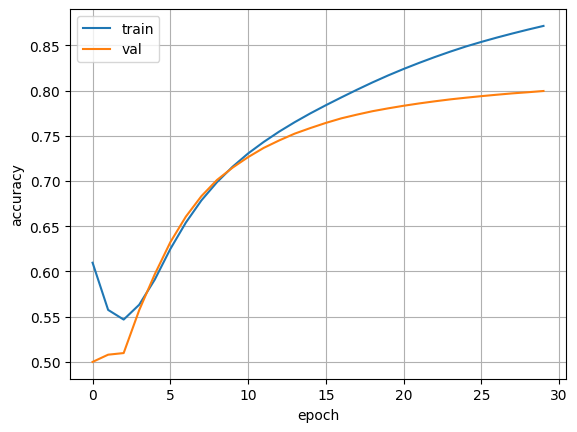

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='train')
plt.plot(accuracy_track['validation'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

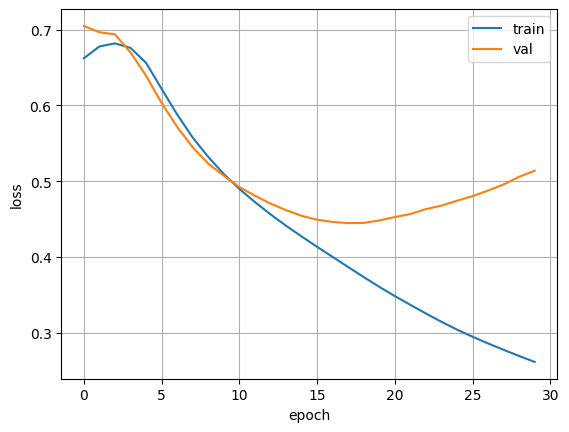

In [24]:
plt.plot(loss_track['training'], label='train')
plt.plot(loss_track['validation'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [25]:
def predict(model, review, seq_length = 200):
    print(review)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    _, words = preprocess(review.lower())
    encoded_words = [vocab_to_int[word] for word in words if word in vocab_to_int.keys()]
    padded_words = pad_text([encoded_words], seq_length)
    padded_words = torch.from_numpy(padded_words).to(device)
    bs=1
    model.eval()
    zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
    h = tuple([zero_init, zero_init])
    output = model(padded_words, h)
    pred = torch.round(output.squeeze())
    out = "This is a positive review." if pred == 1 else "This is a negative review."
    print(out, '\n')


review1 = "Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece"
review2 = "It made me cry"
review3 = "It made me cry - I never seen such an awful acting before"
review4 = "Vulgarity. Ringing vulgarity"
review5 = "Garbage"

predict(model, review1)
predict(model, review2)
predict(model, review3)
predict(model, review4)
predict(model, review5)

Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece
This is a positive review. 

It made me cry
This is a positive review. 

It made me cry - I never seen such an awful acting before
This is a positive review. 

Vulgarity. Ringing vulgarity
This is a positive review. 

Garbage
This is a positive review. 



With the paramiters num_layers = 1, hidden_dim = 256 and embedding_dim = 100 accuracy on test was 76,08% and loss was 0,93.
By increasing all three paramiters in three times the duration of training became much longer and metrics became: accuracy = 79,91% and loss = 1,0.
However, on the train, the model showed significantly better results and gave an accuracy of more than 96%. It means that we have overfitting our model. We will take measures to eliminate the "memorization" of the data model on the train.

Measure 1 - DropOut:
By dropout = 0,2: accuracy = 76,11% and loss = 0,9.

Measure 2 - DropOut + weight decay:
By dropout = 0,3 and weight_decay = 1e-5: accuracy = 80,20% and loss = 0,72.

There is a noticeable increase in the error after passing 10-15 epochs. Also, after 15 epochs, the accuracy does not increase much. You can try to reduce the number of epochs to 15 with the last parameters.
By epoch = 15: accuracy = 75,86% and loss = 0,45.

By epoch = 30: accuracy = 79,96% and loss = 0.51.

